In [1]:
using Plots
using Distributions
using Random, DataFrames
using LinearAlgebra
using MLJ, MLJLinearModels
using Hyperopt
using CSV
include("src/qsrfe.jl")
using .qsrfe

In [2]:
bX, bY = @load_boston
df = DataFrame(bX)
bX = Matrix(DataFrame(bX))
bY = collect(bY)
bX

bX = (bX .- mean(bX)) ./ std(bX)
Y = (bY .- mean(bY)) ./ std(bY)
(xtrain, xtest), (ytrain, ytest) = partition((bX, bY), 0.9, rng=123, multi=true);

In [2]:
df = CSV.read("./data/YearPredictionMSD.txt", DataFrame)
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,2001,1998.4,1922,2002.0,2011,0,Int64
2,49.94357,43.3871,1.749,44.2585,61.9701,0,Float64
3,21.47114,1.28952,-337.092,8.41773,384.066,0,Float64
4,73.07750,8.65822,-301.005,10.4762,322.851,0,Float64
5,8.74861,1.16411,-154.184,-0.652855,335.772,0,Float64
6,-17.40628,-6.55358,-181.953,-6.00777,262.069,0,Float64
7,-13.09905,-9.52197,-81.7943,-11.1884,166.237,0,Float64
8,-25.01202,-2.39105,-188.214,-2.04663,172.403,0,Float64
9,-12.23257,-1.79322,-72.5038,-1.73642,126.741,0,Float64


In [7]:
#y  = collect(df[:,1] .- mean(df[:,1])) ./ std(df[:,1])
function normalize!(x)
    return x = (x .- mean(x)) ./ std(x)
end
function normalizecols!(x)
    for i in 1:size(x,2)
        x[:,i] = normalize!(x[:,i])
    end
    return x
end
y  = convert.(Float64,collect(df[:,1]))
x = normalizecols!(Matrix(df[:,2:end]))
y

515344-element Vector{Float64}:
 2001.0
 2001.0
 2001.0
 2001.0
 2001.0
 2001.0
 2001.0
 2001.0
 2007.0
 2008.0
    ⋮
 2005.0
 2006.0
 2005.0
 2006.0
 2006.0
 2006.0
 2006.0
 2006.0
 2005.0

In [51]:
m = 1000

(xtrain, xtest), (ytrain, ytest) = (x[1:463715,:], x[463716:end,:]), (y[1:463715], y[463716:end])
shuffleorder = shuffle(1:size(xtrain,1))[1:m]
xtrain, ytrain = xtrain[shuffleorder, :], ytrain[shuffleorder]

([0.2382205919647473 0.4892022606305371 … 0.21466205907183722 0.23319435793078985; 0.7288480129676733 -0.4433356089600435 … 0.39289719874643103 -0.516113958117502; … ; -0.2853624303508632 -0.6048778051488959 … -1.2131978422036718 -1.6075884034148749; -1.1261241620396585 -2.7669245258536863 … 0.7174083238705339 -0.8393182680454313], [1982.0, 1994.0, 1999.0, 1956.0, 2009.0, 2004.0, 1998.0, 2005.0, 1982.0, 2009.0  …  2005.0, 2008.0, 1984.0, 1996.0, 2001.0, 2008.0, 2009.0, 1979.0, 1997.0, 2008.0])

In [58]:
model = qsrfe.srfeRegressor(N=8000,λ=0.2,q=1,intercept=true)
c, ω, ζ = qsrfe.fit(model,xtrain,ytrain;verbose=true)
ypred = qsrfe.predict(model,xtest,c, ω, ζ)
ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ)
qsrfe.test_metrics(ytest,ypred,ytrain,ytrainpred)

support: 475/8001

MSE: 96.4823266553586 train MSE: 83.96731296681057
rel: 0.0035638572369956173 train rel: 0.0033074930856209672


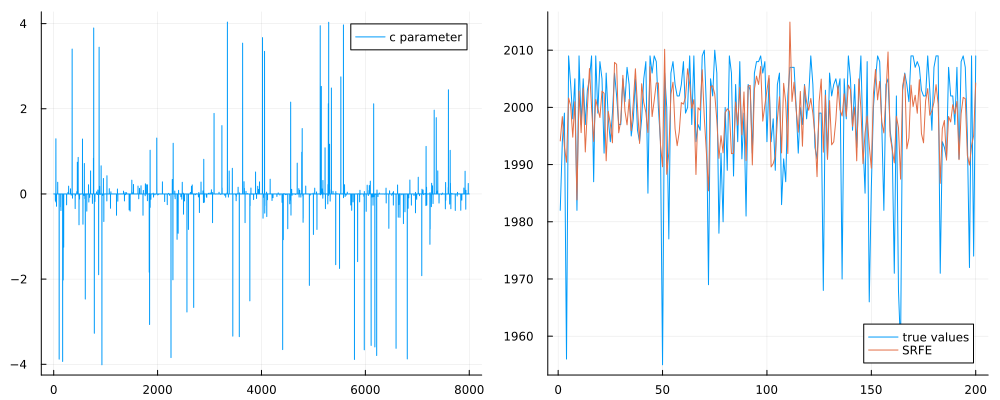

In [ ]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[1:200], label="true values")
plot!(ytrainpred[1:200], label="SRFE")
plot(p1,p2,layout=2,size=(1000,400))


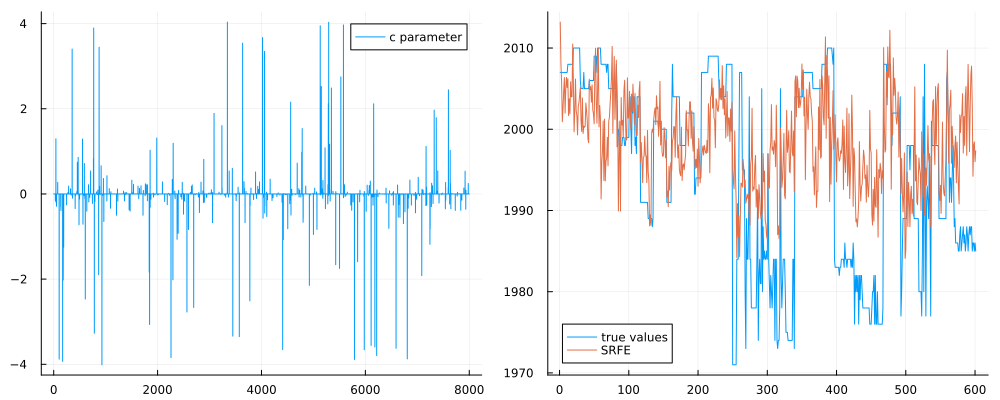

In [60]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytest[200:800], label="true values")
plot!(ypred[200:800], label="SRFE")
plot(p1,p2,layout=2,size=(1000,400))

In [ ]:
model = qsrfe.srfeRegressor(N=16384,λ=0.2,)
#quantizer = qsrfe.MSQ(K=2)
#quantizer = qsrfe.ΣΔQ(K=2,r=1,λ=2,condense=false)
quantizer = qsrfe.βQ(K=4,β=4.5,λ=16,condense=true)
c, ω, ζ = qsrfe.fit(model,xtrain,ytrain,quantizer;verbose=true)
ypred = qsrfe.predict(model,xtest,c, ω, ζ, quantizer)
ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ,quantizer)
qsrfe.test_metrics(ytest,ypred,ytrain,ytrainpred)